In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data_path = r"/shared/netscratch/znjs2/atom_data_02_20/processed/all_atom_ch4_data_datetime.csv"

In [3]:
ch4_data = pd.read_csv(data_path, delimiter=',', 
                        na_values = [-99999, -9999, -999, -888], 
                        parse_dates=[0], 
                        index_col=0)

#Get rid of NA valss
ch4_data = ch4_data.dropna(subset=['CH4_PECD'])
print(ch4_data.shape)

#print(ch4_data.iloc[:3])

(7208, 9)


In [4]:
#check which months present
months_present, counts = np.unique(pd.DatetimeIndex(ch4_data.index).month, return_counts=True)

print(np.asarray((months_present, counts)).T)

[[   1  376]
 [   2 1317]
 [   4  487]
 [   5 1608]
 [   7  160]
 [   8 1368]
 [   9  199]
 [  10 1693]]


In [4]:
#add month column
#ch4_data['month'] = pd.DatetimeIndex(ch4_data.index).month

In [5]:
#bin by latitude
ch4_data['lat_bins'] = pd.cut(ch4_data.iloc[:,0],[-90,-60,-30,0,30,60,90], 
                              labels=list(range(6)))

In [6]:
#print(ch4_data.iloc[:3])

In [7]:
#make seperate data frame for each month
monthly_ch4 = {}
for x in range(len(months_present)):
        monthly_ch4[f'ch4_{months_present[x]}'] = ch4_data[pd.DatetimeIndex(ch4_data.index).month == months_present[x]]
    
#print(monthly_ch4)

In [27]:
#bin data by season
ch4_jf = pd.concat((monthly_ch4.get('ch4_7'),monthly_ch4.get('ch4_8')))
print(monthly_ch4.get('ch4_1').shape)
print(monthly_ch4.get('ch4_2').shape)
print(ch4_jf.shape)

(376, 10)
(1317, 10)
(1528, 10)


In [28]:
print(ch4_jf[:3])

                        G_LAT     G_LONG   G_ALT  CH4_PECD  CH4e_PECD  \
UTC_Start_dt                                                            
2016-07-29 15:51:44  26.63903 -120.51696  3076.9    1809.9       20.8   
2016-07-29 15:54:04  26.41987 -120.51722  2077.6    1816.7       20.8   
2016-07-29 15:56:24  26.22611 -120.51680  1271.7    1833.2       20.8   

                     CH4_GMI  CH4_NOAA  CH4_UCATS  CH4e_UCATS lat_bins  
UTC_Start_dt                                                            
2016-07-29 15:51:44      NaN       NaN        NaN         NaN        3  
2016-07-29 15:54:04      NaN   1828.19        NaN         NaN        3  
2016-07-29 15:56:24      NaN       NaN        NaN         NaN        3  


In [29]:
#how many data points in each lat bin?
lat_bins, counts = np.unique(ch4_jf.iloc[:,9], return_counts=True)
print(lat_bins)
print(np.asarray((lat_bins, counts)).T)

[0 1 2 3 4 5]
[[  0 106]
 [  1 285]
 [  2 181]
 [  3 271]
 [  4 377]
 [  5 308]]


In [39]:
#should define a function for this

lat_bands_obs_jf = np.empty((6,50))
base_obs_jf = np.zeros(6)

yvals = np.linspace(0,12000)

for i in range(6):
    #select data by latitude band
    lat_band = ch4_jf.loc[ch4_jf['lat_bins'] == i].iloc[:,[0,2,3]].dropna()
    #generate coefficients and make function
    coefs = np.polyfit(lat_band.iloc[:,1],lat_band.iloc[:,2],3)
    fit = np.poly1d(coefs)
    base_obs_jf[i] = fit(0) #set zero value
    lat_bands_obs_jf[i] = fit(yvals)
    
print(lat_bands_obs_jf.shape)
np.save('/shared/netscratch/znjs2/atom_data_02_20/ch4_lat_binned_ja_3.npy', lat_bands_obs_jf)

(6, 50)


Text(0.5, 1.0, 'CH4 Profile')

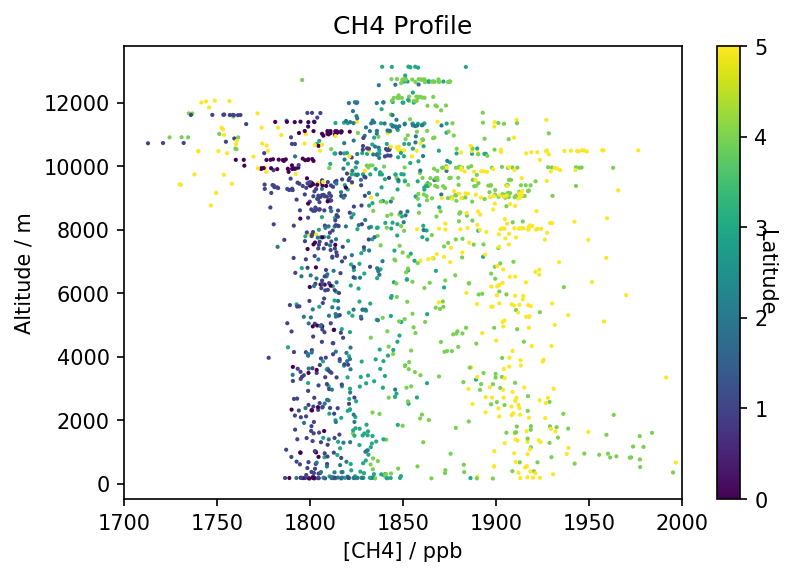

In [36]:
fig = plt.figure(dpi=150)
ax = plt.axes()
plot = ax.scatter(ch4_jf.iloc[:,3],ch4_jf.iloc[:,2],s=1, c=ch4_jf.iloc[:,9])

cbar = plt.colorbar(plot)
cbar.set_label('Latitude', rotation=270)
ax.set_xlim(1700,2000)
plt.xlabel('[CH4] / ppb')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile')

Text(0.5, 1.0, 'CH4 Profile: model with emissions (xltln) JA')

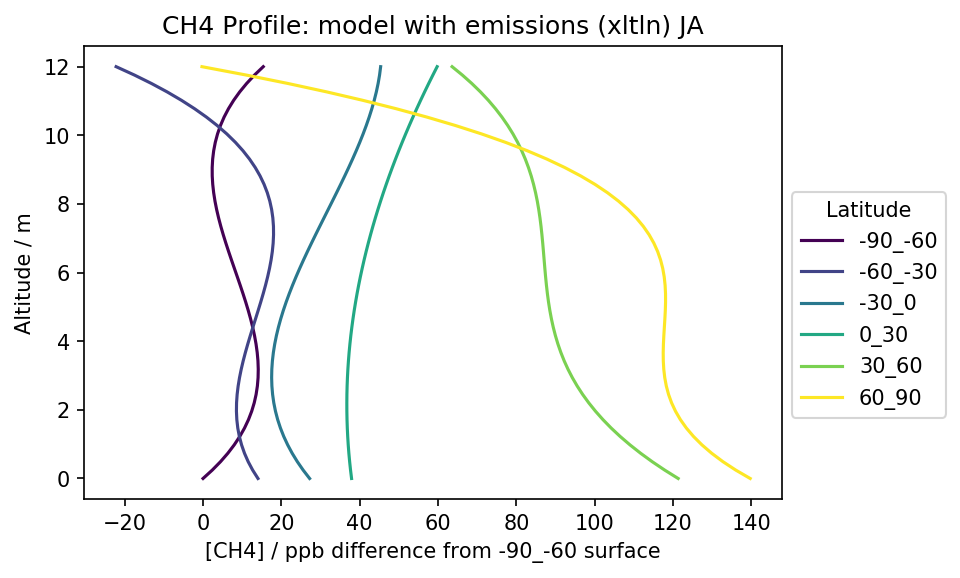

In [38]:
fig = plt.figure(dpi=150)
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('viridis')

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

for i in range(6):
    #ax.plot(lat_mean - base[0], alt, label=f'{i} to {i+30}',c=cmap((i+90)/150))
    ax.plot(lat_bands_obs_jf[i,:] - base_obs_jf[0], yvals/1000, c=cmap(i/5) ,label=f'{plt_labels[i]}')
    
plt.legend(title='Latitude',bbox_to_anchor=(1.25,0.7))
#ax.set_ylim(0,12000)
#ax.set_xlim(-250,250)
plt.xlabel('[CH4] / ppb difference from -90_-60 surface')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile: model with emissions (xltln) JA')

Text(0.5, 1.0, 'CH4')

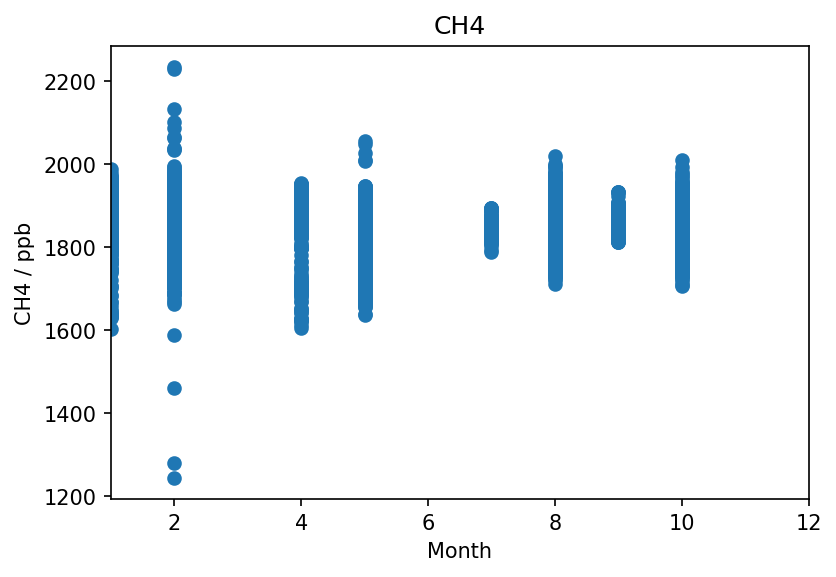

In [26]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.scatter(pd.DatetimeIndex(ch4_data.index).month,ch4_data.iloc[:,3])
ax.set_xlim(1,12)
plt.xlabel('Month')
plt.ylabel('CH4 / ppb')
plt.title(f'CH4')